
# Deep Neural network

In [1]:
!pip install pyprind

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


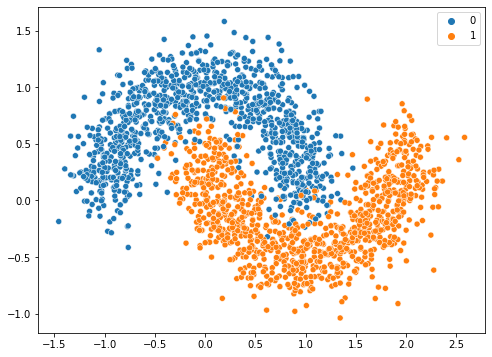

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from pprint import pprint
from sklearn.datasets import make_moons ,make_friedman1

X , y = make_moons(n_samples=2000,
                     shuffle=True,
                     noise=0.2)


plt.figure(figsize=(8,6))
sns.scatterplot(x = X[:,0] , y = X[:,1],hue = y)
plt.show()

In [3]:
import pyprind as pr

class NeuralNetwork:

  np.random.seed(3)
  
  def __init__(self,arch,lambd,l2=False):
    self.arch = arch
    self.n_params = len(self.arch) 
    self.lambd = lambd
    self.l2 = l2
    self.params = dict()
    self.relu = lambda x : np.sin(x)*x
    self.sigm = lambda x : 1 / (1 + np.e**-x)

    for p in range(1, self.n_params):
        #xavier weights initialization
        self.params[f'W{p}'] = np.random.randn(self.arch[p], self.arch[p-1]) * np.sqrt(2.0/self.arch[p-1])

        self.params[f'b{p}'] = np.zeros((self.arch[p], 1))

    self.L = len(self.params) // 2 


  def forwardprop(self,X):

    tfs = dict() 

    tfs["A0"]  = X.T 

    for l in range(1,self.L):

       Z = np.dot(self.params[f"W{l}"],tfs[f"A{l - 1}"]) + self.params[f"b{l}"]

       tfs[f"Z{l}"] = Z

       tfs[f"A{l}"] = self.relu(Z)

    Z = np.dot(self.params[f"W{self.L}"],tfs[f"A{self.L-1}"]) + self.params[f"b{self.L}"]

    tfs[f"Z{self.L}"] = Z

    tfs[f"A{self.L}"] = self.sigm(Z)

    return  tfs

  def backprop(self,X,y,tfs,l2):

    y = y.reshape(1,y.shape[0])

    m = y.shape[1]

    grads = dict() 

    #Error  L-layer
    dL = (tfs[f"A{self.L}"] - y)

    if l2:
      grads[f"dW{self.L}"] = (1/m)*np.dot(dL,tfs[f"A{self.L - 1}"].T) + (self.lambd/m)*self.params[f"W{self.L}"]

      grads[f"db{self.L}"] = (1/m)*np.sum(dL,keepdims=True,axis=1) + (self.lambd/m)*self.params[f"b{self.L}"]

    else:
      grads[f"dW{self.L}"] = (1/m)*np.dot(dL,tfs[f"A{self.L - 1}"].T)

    grads[f"db{self.L}"] = (1/m)*np.sum(dL,keepdims=True,axis=1)

    for l in reversed(range(1,self.L)):

      #Error L-1 layer
      
      dL =  (self.params[f"W{l + 1}"].T @ dL)  * self.derivate(self.relu,tfs[f"Z{l}"])
      
      if l2:
        grads[f"dW{l}"] = (1/m)*np.dot(dL,tfs[f"A{l - 1}"].T) + (self.lambd/m)*self.params[f"W{l}"]

        grads[f"db{l}"] = (1/m)*np.sum(dL,keepdims=True,axis=1) + (self.lambd/m)*self.params[f"b{l}"]
      else:
        grads[f"dW{l}"] = (1/m)*np.dot(dL,tfs[f"A{l - 1}"].T)

      grads[f"db{l}"] = (1/m)*np.sum(dL,keepdims=True,axis=1)

    return grads 

  def gradient_descent(self,grads,lr):

    for l in range(1,self.L):

      self.params[f"W{l}"] = self.params[f"W{l}"] - lr*grads[f"dW{l}"]

      self.params[f"b{l}"] = self.params[f"b{l}"] - lr*grads[f"db{l}"]


  def train(self,X,y,epochs,lr=0.01):

    costs = list()
    cost = 0

    bar = pr.ProgBar(epochs,bar_char='#')

    for epoch in range(epochs):

      tfs = self.forwardprop(X)

      if self.l2:
        cost = self.l2_cost(tfs[f"A{self.L}"],y)
      else:
        cost = self.cost(tfs[f"A{self.L}"],y)

      costs.append(cost)

      grads = self.backprop(X,y,tfs,self.l2)

      self.gradient_descent(grads,lr)

      bar.update(item_id=f"acc: {round(accuracy_score(self.predict(X),y),4)} cost: {cost}")


    return costs

  def predict(self,X):

    TRESH = 0.5

    y_hat = np.array([1 if  i >= TRESH else 0 for i in  self.forwardprop(X)[f"A{self.L}"][0,:]]) 

    return y_hat


  @staticmethod
  def cost(y_hat,y):

    y = y.reshape(1,y.shape[0])

    m = y.shape[1]

    J = lambda y_hat , y : -(1/m)*np.sum(( y*np.log(y_hat) +  (1 - y) *np.log(1 - y_hat)))
    
    J = np.squeeze(J(y_hat,y))   

    return J

  def l2_cost(self,y_hat,y):

    y = y.reshape(1,y.shape[0])

    m = y.shape[1]
    W_ = 0

    for l in range(1,self.n_params):

      W_ += np.sum(np.square(self.params[f"W{l}"]))

    J = lambda y_hat , y : (-(1/m)*np.sum(( y*np.log(y_hat) +  (1 - y) * np.log(1 - y_hat)))) + (1/m)*(self.lambd/2)*W_

    J = np.squeeze(J(y_hat,y))

    return J   


  @staticmethod
  def derivate(func,x,h=0.0000000001):
    return (func(x + h) - func(x)) / h


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X_train , X_test ,y_train ,y_test = train_test_split(X,y,test_size=0.3,random_state=101)


net_structure = [2,4,8,4,2,1]

nn = NeuralNetwork(arch = net_structure,lambd=0.00001,l2=True)

error = nn.train(X_train,y_train,epochs=10000,lr=0.03)

0% [##############################] 100% | ETA: 00:00:00 | Item ID: acc: 0.9593 cost: 0.32754656323630166
Total time elapsed: 00:00:41


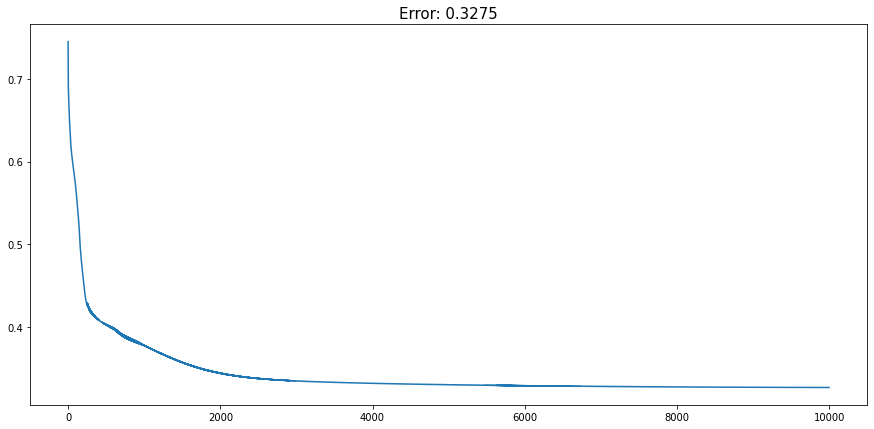

In [5]:
plt.figure(figsize=(15,7))
plt.plot(range(len(error)),error)
plt.title(f"Error: {round(error[-1],4)}",fontsize=15)
plt.show()

In [6]:
print(f"""

Train accuracy: {accuracy_score(nn.predict(X_train),y_train)}
Test accuracy:  {accuracy_score(nn.predict(X_test),y_test)}

""")



Train accuracy: 0.9592857142857143
Test accuracy:  0.9616666666666667




In [7]:
def plot_decision_region(X,y,clf,res,y_labels,title,size,k):

  colors = ['blue','orange']
  markers = ['o','o']

  x_min, x_max = X[:, 0].min() - k, X[:, 0].max() + k
  y_min, y_max = X[:, 1].min() - k, X[:, 1].max() + k

  xx, yy = np.meshgrid(np.arange(x_min, x_max, res),
                        np.arange(y_min, y_max, res))

 
  Z = clf.predict(np.array([xx.ravel(), yy.ravel()]).T)

  Z = Z.reshape(xx.shape)

  plt.figure(figsize=size)
  plt.contourf(xx,yy,Z,alpha=0.5,cmap='Spectral')
  plt.xlim(xx.min(),xx.max())
  plt.ylim(yy.min(),yy.max())
  plt.title(title,fontsize=18)

  for class_ in np.unique(y):

    plt.scatter(x=X[y == class_,0],y=X[y == class_,1],alpha=0.8,
                color=colors[class_],marker=markers[class_],
                label=y_labels[class_])
    
  plt.legend()
  plt.xlabel('X1',fontsize=18)
  plt.ylabel('X2',fontsize=18)
  plt.show()


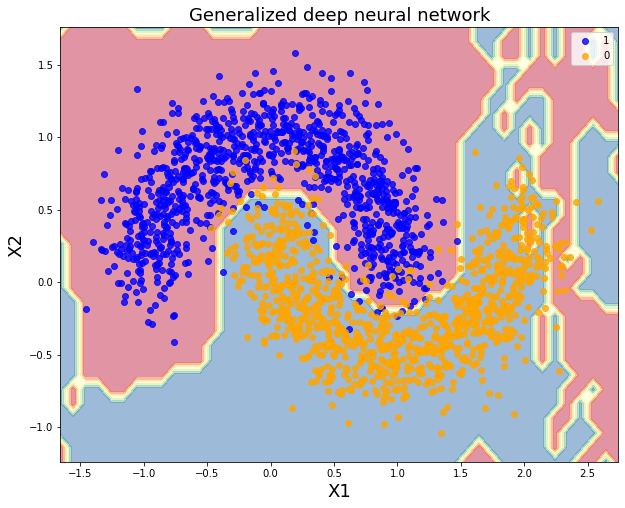

In [8]:
plot_decision_region(X,y,nn,
                     res=0.1,
                     y_labels=["1","0"],
                     title="Generalized deep neural network",
                     size=(10,8),
                     k=0.2)